# **Using neural network to solve ODE**

**Example 1:** Solve the following ODE:
$$y'(x)=-22(x-1)y(x), \quad y(0)=e^{-7}.$$
The exact solution is $y(x)=e^{4-(11-x)^2}$

**Method:** We will try to optimize a loss function to force it match where the loss function is defined by the equation and the initial condition(s). The model is adapted from the deep network model.<br>
In this example we use 1 hidden fully connected hidden layer(size 10) network

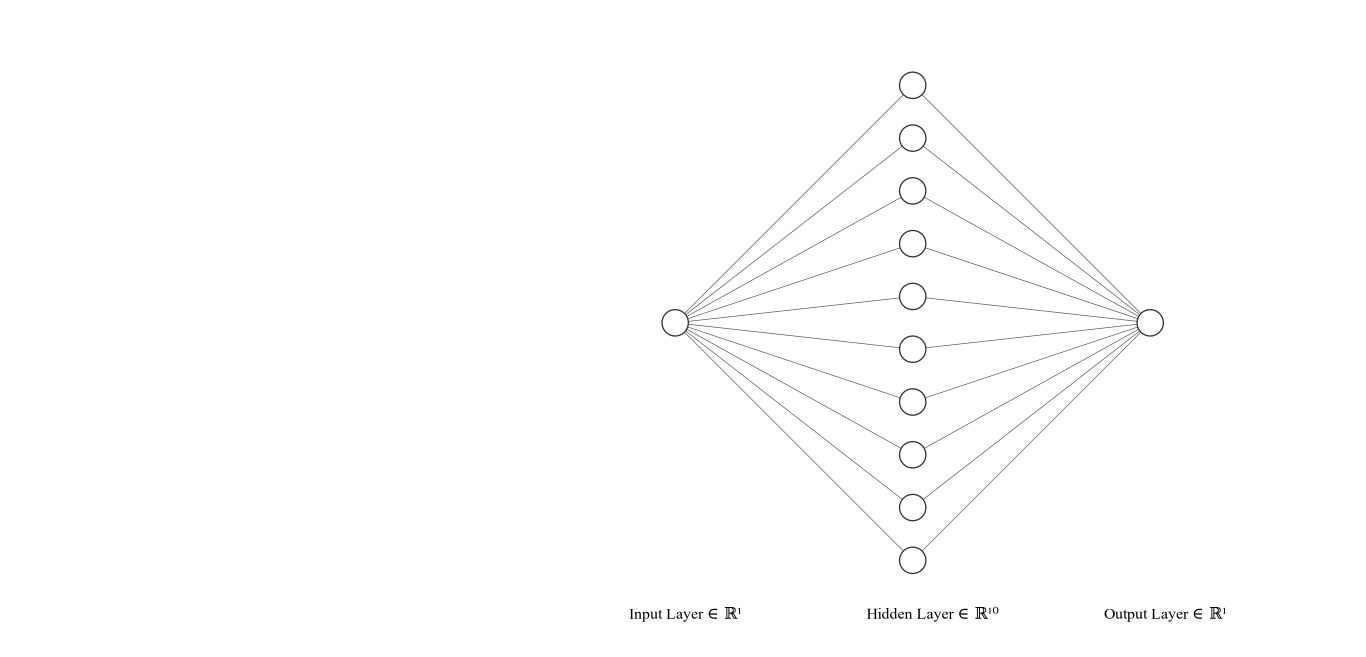

In [43]:
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
import numpy as onp

In [44]:
#Define the relu function.
def relu(x):
  return np.where(x > 0, x, 0.0)
# Define the f function
def f(y,x):
  return -22*(x-1)*y

#From weights and bias (params)and the input (x) compute the output
def neural_network(params, x):
    w0 = params[:10]
    b0 = params[10:20]
    w1 = params[20:30]    
    b1 = params[30]
    x = relu(x*w0 + b0) 
    x = np.sum(x*w1) + b1
    return x

In [64]:
#Initialization
T=2
N=10 # Number of hidden layers
t=np.linspace(0, T, N+1) 
x=onp.zeros(N+1) ##
s=onp.zeros(N+1) ## slope vector
x[0]=np.exp(-7)
a1 = onp.ones(N)
b1 = - t[0:N]
a2 = onp.zeros(N)
## Explicit Euler method initilazation
for i in range(1,N+1):
  s[i]=f(x[i-1],t[i-1])
  x[i]=x[i-1]+T/N * s[i]
for i in range(N):
  a2[i] = s[i+1]-s[i]
b2 = np.exp(-7)
w1 = np.concatenate((a1,b1) , axis = None)
w2 = np.concatenate((a2,b2) , axis = None)
params = np.concatenate((w1,w2) , axis = None)

In [73]:
print(a1,a2,b1,b2)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] [ 0.0200614   0.06660386  0.20712999  0.41914782  0.27091837 -0.98386145
 -1.84965992  1.40574232  0.94998363 -1.61266369] [-0.  -0.2 -0.4 -0.6 -0.8 -1.  -1.2 -1.4 -1.6 -1.8] 0.000911882


In [65]:
# Solving the ODE in the closed interval [0;2] with the number of time interval:10
inputs = np.linspace(0., 2., num=11) ### Note that: The number of hiddens layers must be equal to the number of time intervals (in this method)

# Vectorize those functions using vmap

f_vect = vmap(neural_network, (None, 0)) #(None, 0) specifies that each function is to be mapped over the 0-axis of the second argument (x)



In [66]:
#Define the loss function
def loss(params,t):
  N=10;
  x= f_vect(params, t)
  ## Gaussian quadrature coeffcients
  r0=0.5*(1-1/np.sqrt(3))
  r1=0.5*(1+1/np.sqrt(3))
  err= x[1:]-x[:N]-0.1*(f(r0*x[:N]+(1-r0)*x[1:],  r0*t[:N]+(1-r0) *t[1:]) + f(r1*x[:N]+(1-r1)*x[1:],  r1*t[:N]+(1-r1) *t[1:]) )
  ## Regularization
  y=1/(np.sqrt(x[1:]**2+1))
  return np.sum(y*(err**2));

In [67]:
loss(params, inputs)

DeviceArray(0.2568314, dtype=float32)

In [68]:
grad_loss = jit(grad(loss, 0)) # JIT (just-in-time compilation) on this function to speed up its execution on accelerator hardware if available.

In [69]:
#Gradient desent
epochs =1000
learning_rate = 0.001

for epoch in range(epochs):
    if epoch % 100 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss(params, inputs)))
    gradient = grad_loss(params , inputs)
    params = params - learning_rate*gradient

epoch:   0 loss: 0.256831
epoch: 100 loss: 4.175790
epoch: 200 loss: 1.286085
epoch: 300 loss: 0.405849
epoch: 400 loss: 0.135353
epoch: 500 loss: 0.065465
epoch: 600 loss: 0.040377
epoch: 700 loss: 0.038567
epoch: 800 loss: 0.036085
epoch: 900 loss: 0.030556


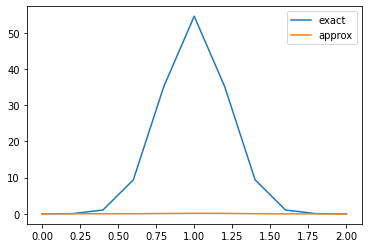

In [70]:
import matplotlib.pyplot as plt

plt.plot(inputs, np.exp(4-11*(inputs-1)**2), label='exact')
plt.plot(inputs, f_vect(params, inputs), label='approx')
plt.legend()
plt.show()

In [71]:
f_vect(params, inputs)

DeviceArray([-0.00163124, -0.00165565,  0.00115809,  0.01834308,
              0.07755169,  0.1321478 ,  0.10644931,  0.02576813,
             -0.03208586, -0.0235736 , -0.03371829], dtype=float32)